<a href="https://colab.research.google.com/github/Mariamibrahim223/Chen_plasma_physics/blob/main/Proj_Ch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import animation, rc
rc('animation', html='html5')
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import imageio.v2 as imageio   # for making GIFs
import os

# PIC Simulation

We will consider a one-dimensional system of particles. The particles will be described by N particles, indexed by i, each having a position $r_i$, velocity $v_i$.

They feel an acceleration $a_i$ which is due to the electric field $E$ at the location of the particle. The equations of motion for the electrons are given by:

$$
\frac{dr_i}{dt} = v_i, \qquad \frac{dv_i}{dt} = a_i = \frac{F_i}{m_i}
$$


where $F$ could be:
$$
F_i = q_i E_i \qquad \text{For electrostatic cases}
$$

$$
F_i = q_i ( E_i + v_i B_i )  \qquad \text{For electromagnetic cases}
$$

What remains to be done is to calculate the electric field $E$, which depends on the number density $n$ of the electrons. The electric field $E$ is defined as the negative gradient of the electric potential $\phi$, which is given by Poisson's equation sourced by the density:

$$
E(x) = -\frac{d\phi}{dx}, \qquad \frac{d^2 \phi(x)}{dx^2} = n-n_0
$$

where $n_0$ is the average electron density (a constant).

The Particle-In-Cell (PIC) Method computes the density and subsequently the potential and electric field on a mesh. Hence it is called a particle-mesh method. The electric field is then extrapolated onto the location of the particles in order to advance them.

**Charge Deposition (CIC)**

The density is obtained by binning the particles onto the mesh gridpoints. Call the separation distance between mesh points $\Delta x$. A particle with position $x_p$ will lie between a pair of coordinates $x_j$ and $x_{j+1}$ on the mesh. Then, the densities $\rho_j$ and $\rho_{j+1}$ at these two points gain a contribution:

$$
\rho_j += q\Big(1-\frac{x_p - x_j}{\Delta x} \Big), \qquad \rho_{j+1} += q \Big(\frac{x_p - x_j}{\Delta x} \Big)
$$

After collecting contribution from all particles, the density has to be properly normalized so that the average density is the specified $\rho_0$.

**Potential Calculation**


$$
\nabla^2 \phi(x) = -\frac{\rho}{\epsilon_0}
$$

In Fourier space:

$$
-k^2 \phi_k \approx -\frac{\rho_k}{\epsilon_0}
$$

So:
$$
\phi_k = \frac{\rho_k}{\epsilon_0 k^2}
$$

Then the electric field is:

$$
E_k = -ik \phi_k \Rightarrow  \quad E(x) = \mathcal{F}^{-1} (E_k)
$$

Each particle samples the field at its position. Using CIC:

$$
E(x_p) = E_j \Big( 1- \frac{x_p -x_j}{\Delta x} \Big) + E_{j+1} \Big( \frac{x_p - x_j}{\Delta x} \Big)
$$

**Time Integration**

We will loop over timesteps and evolve the electrons using a leap-frog scheme (kick-drift-kick). For each timestep $\Delta t$, each particle receives a half-step 'kick':

$$
v_i = v_i + \frac{\Delta t}{2} a_i
$$

followed by a full-step 'drift':
$$
r_i = r_i + \Delta t v_i
$$


followed by another half-step 'kick'.

**Initial Conditions**

The only thing left to do is specify the initial conditions (positions and velocities at time $t=0$)

This, of course, could be generalized to 2D/3D case.

For relativstic correction, we update the momentum instead of velocity in the leap-frog algorithm.


In [ ]:
def CIC(pos, E_grid, N_x, L, q_particle):
    dx = L / N_x
    Np = pos.size
    j = np.floor(pos / dx).astype(int).flatten()
    jp1 = (j + 1) % N_x
    wt_jp1 = ((pos - j * dx) / dx).flatten()
    wt_j = (1.0 - wt_jp1).flatten()
    n_counts = np.bincount(j, weights=wt_j, minlength=N_x) + np.bincount(jp1, weights=wt_jp1, minlength=N_x)
    n_grid = n_counts * (q_particle / dx)
    Ep = wt_j * E_grid[j] + wt_jp1 * E_grid[jp1]
    return Ep

def poisson_fft(n_grid, n0, L):
    Nx = n_grid.size
    dx = L / Nx
    rho = n_grid - n0
    rho -= np.mean(rho)
    rho_k = np.fft.rfft(rho)
    k = 2.0 * np.pi * np.fft.rfftfreq(Nx, d=dx)
    phi_k = np.zeros_like(rho_k, dtype=complex)
    nonzero = k != 0.0
    phi_k[nonzero] = - rho_k[nonzero] / (k[nonzero]**2)
    phi = np.fft.irfft(phi_k, n=Nx)
    E_k = -1j * k * phi_k
    E_grid = np.fft.irfft(E_k, n=Nx)
    return E_grid, phi

def acc(F, m):
    return F / m

## Two-Stream Instability:

When two beams of plasma species move relative to each other, the extra velocity can excite the other beam.

In [ ]:
def two_stream_instability():
    # Parameters
    N, Nx, L = 40000, 400, 50
    tEnd, dt = 50, 1
    n0, vb, vth, A, q, m = 1, 3, 1, 0.1, -1, 1
    Nt, Nh = int(np.ceil(tEnd / dt)), int(N/2)
    dx = L / Nx

    # Initial conditions
    np.random.seed(42)
    pos = np.random.rand(N,1) * L
    vel = vth * np.random.randn(N,1) + vb
    vel[Nh:] *= -1
    vel *= 1 + A * np.sin(2 * np.pi * pos / L)

    # Initial density
    n_grid = np.bincount(np.floor(pos.flatten() / dx).astype(int),
                         weights=(1.0 - (pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                         minlength=Nx) + \
             np.bincount((np.floor(pos.flatten() / dx).astype(int) + 1) % Nx,
                         weights=((pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                         minlength=Nx)
    n_grid *= (n0 * L / N) / dx

    E_grid, phi = poisson_fft(n_grid, n0, L)
    Ep = CIC(pos.flatten(), E_grid, Nx, L, q)
    F = q * Ep
    a = acc(F, m)
    vel += 0.5 * a.reshape(-1, 1) * dt

    # Folder for frames
    if not os.path.exists("frames"):
        os.makedirs("frames")

    frames = []
    t = 0
    for i in range(Nt):
        pos += vel * dt
        pos = np.mod(pos, L)

        n_grid = np.bincount(np.floor(pos.flatten() / dx).astype(int),
                             weights=(1.0 - (pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                             minlength=Nx) + \
                 np.bincount((np.floor(pos.flatten() / dx).astype(int) + 1) % Nx,
                             weights=((pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                             minlength=Nx)
        n_grid *= (n0 * L / N) / dx

        E_grid, phi = poisson_fft(n_grid, n0, L)
        Ep = CIC(pos.flatten(), E_grid, Nx, L, q)
        F = q * Ep
        a = acc(F, m)
        vel += a.reshape(-1, 1) * dt / 2.0
        t += dt

        # Save frames every few steps
        if i % 2 == 0:
            fig, ax = plt.subplots(figsize=(6,4))
            ax.scatter(pos[0:Nh], vel[0:Nh], s=0.4, color="blue", alpha=0.5)
            ax.scatter(pos[Nh:], vel[Nh:], s=0.4, color="red", alpha=0.5)
            ax.set_xlim(0, L)
            ax.set_ylim(-6, 6)
            ax.set_xlabel("x")
            ax.set_ylabel("v")
            ax.set_title(f"Two-Stream Instability t={t:.1f}")
            frame_path = f"frames/frame_{i:04d}.png"
            plt.savefig(frame_path, dpi=100)
            plt.close()
            frames.append(frame_path)

    # Make GIF
    images = [imageio.imread(f) for f in frames]
    imageio.mimsave("twostream.gif", images, duration=0.15)

if __name__ == "__main__":
    two_stream_instability()

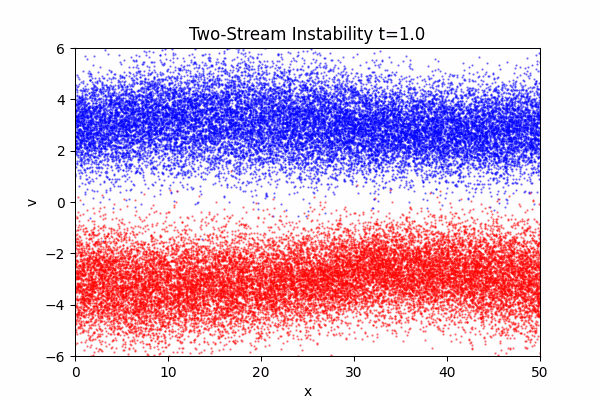

In [ ]:
from IPython.display import Image
Image(filename="twostream.gif")